# Step 1. Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('ecommerce_customer_data_large.csv')

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64


In [4]:
# Handling missing values
df['Customer Age'].fillna(df['Customer Age'].median(), inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

In [5]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [6]:
# Convert 'Purchase Date' to datetime format
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

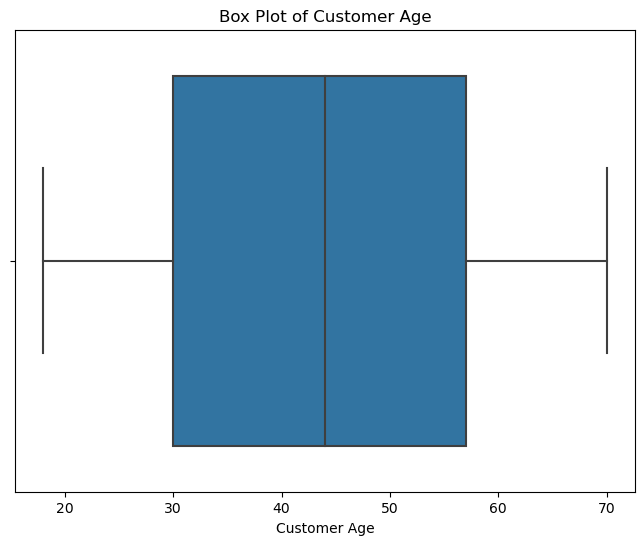

In [7]:
# Detect outliers using visualization or statistical methods
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Customer Age'])
plt.title('Box Plot of Customer Age')
plt.xlabel('Customer Age')
plt.show()

In [8]:
# Handle outliers (e.g., remove or cap extreme values)
df = df[df['Customer Age'] <= 100]

# Step 2. Exploratory Data Analysis(EDA)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate basic statistics
basic_stats = df[['Total Purchase Amount']].describe()
print("Basic Statistics for Total Purchase Amount:\n", basic_stats)

Basic Statistics for Total Purchase Amount:
        Total Purchase Amount
count          250000.000000
mean             2725.385196
std              1442.576095
min               100.000000
25%              1476.000000
50%              2725.000000
75%              3975.000000
max              5350.000000


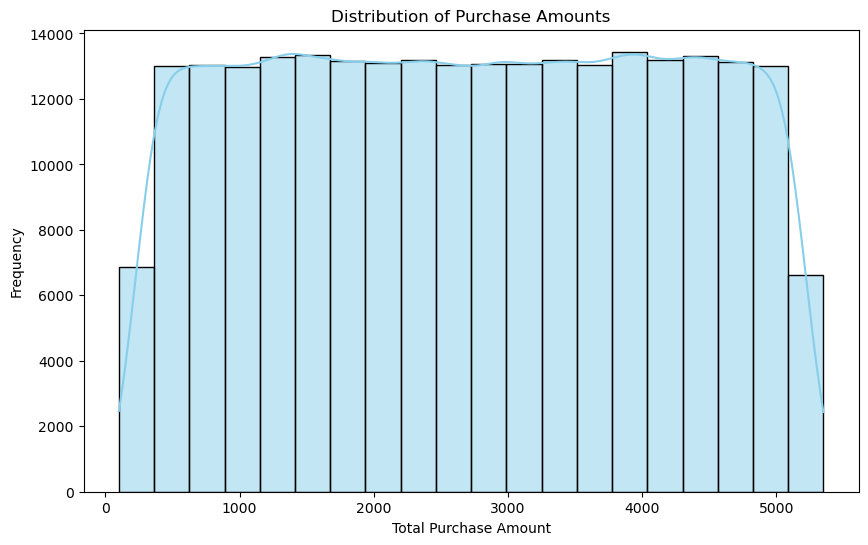

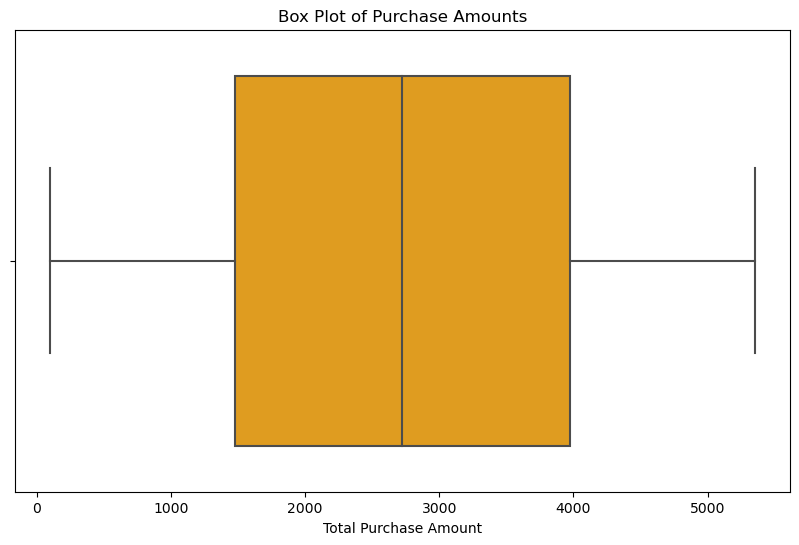

In [10]:
# Visualize the distribution of purchase amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['Total Purchase Amount'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Total Purchase Amount')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Total Purchase Amount'], color='orange')
plt.title('Box Plot of Purchase Amounts')
plt.xlabel('Total Purchase Amount')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_7252\2167411581.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Month', y='Total Purchase Amount', data=df, estimator=sum, ci=None)


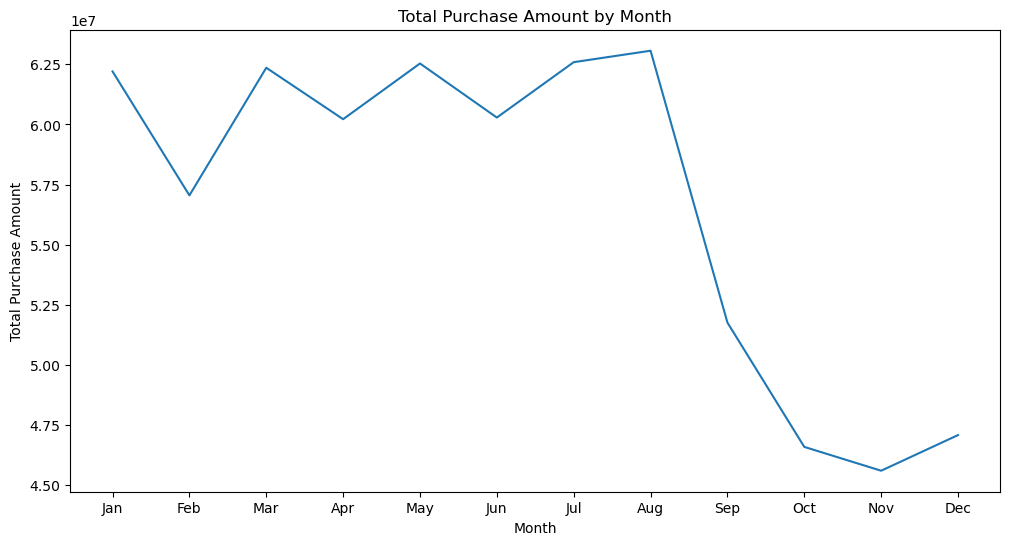

In [12]:
# Analyze trends in customer purchasing behavior over time
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df['Month'] = df['Purchase Date'].dt.month

plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Total Purchase Amount', data=df, estimator=sum, ci=None)
plt.title('Total Purchase Amount by Month')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [13]:
# Identify top-selling products or product categories based on purchase frequency or revenue
top_products = df['Product Category'].value_counts().nlargest(5)
print("Top 5 Selling Product Categories:\n", top_products)

top_revenue = df.groupby('Product Category')['Total Purchase Amount'].sum().nlargest(5)
print("Top 5 Product Categories by Revenue:\n", top_revenue)

Top 5 Selling Product Categories:
 Electronics    62630
Clothing       62581
Home           62542
Books          62247
Name: Product Category, dtype: int64
Top 5 Product Categories by Revenue:
 Product Category
Home           171138916
Clothing       170716122
Electronics    170146025
Books          169345236
Name: Total Purchase Amount, dtype: int64


# Step 3. RFM Analysis

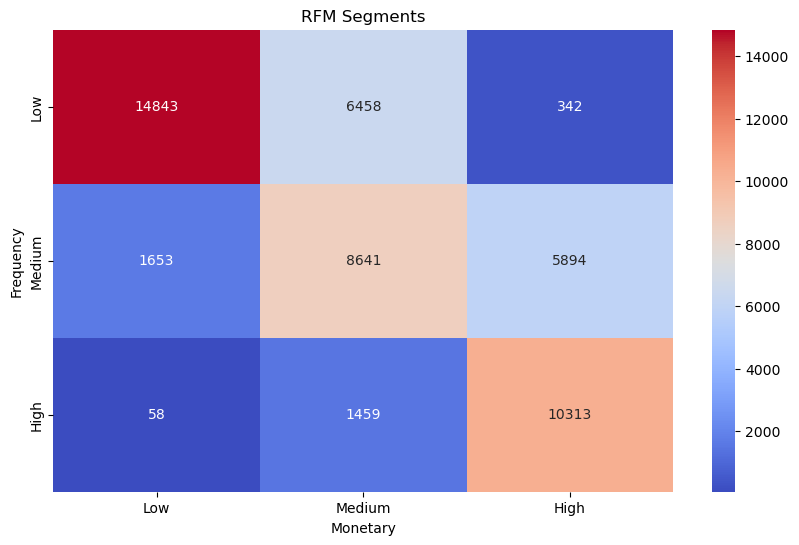

In [16]:
# Calculate Recency, Frequency, and Monetary Value for each customer
snapshot_date = df['Purchase Date'].max() + pd.DateOffset(days=1)
rfm_table = df.groupby('Customer ID').agg({
    'Purchase Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Customer Name': 'count',  # Frequency (assuming 'Customer Name' is unique per purchase)
    'Total Purchase Amount': 'sum'  # Monetary Value
}).reset_index()

# Rename columns for clarity
rfm_table.rename(columns={
    'Purchase Date': 'Recency',
    'Customer Name': 'Frequency',
    'Total Purchase Amount': 'Monetary'
}, inplace=True)

# Assign RFM scores
rfm_table['R_score'] = pd.qcut(rfm_table['Recency'], q=3, labels=['High', 'Medium', 'Low'])
rfm_table['F_score'] = pd.qcut(rfm_table['Frequency'], q=3, labels=['Low', 'Medium', 'High'])
rfm_table['M_score'] = pd.qcut(rfm_table['Monetary'], q=3, labels=['Low', 'Medium', 'High'])

# Combine RFM scores into RFM tiers
rfm_table['RFM_tier'] = rfm_table['R_score'].astype(str) + rfm_table['F_score'].astype(str) + rfm_table['M_score'].astype(str)

# Visualize RFM segments using a heatmap
rfm_pivot = rfm_table.pivot_table(index='F_score', columns='M_score', values='Recency', aggfunc='count')
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_pivot, annot=True, cmap='coolwarm', fmt="g")
plt.title('RFM Segments')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.show()

# Step 4. Customer Segmentation

C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


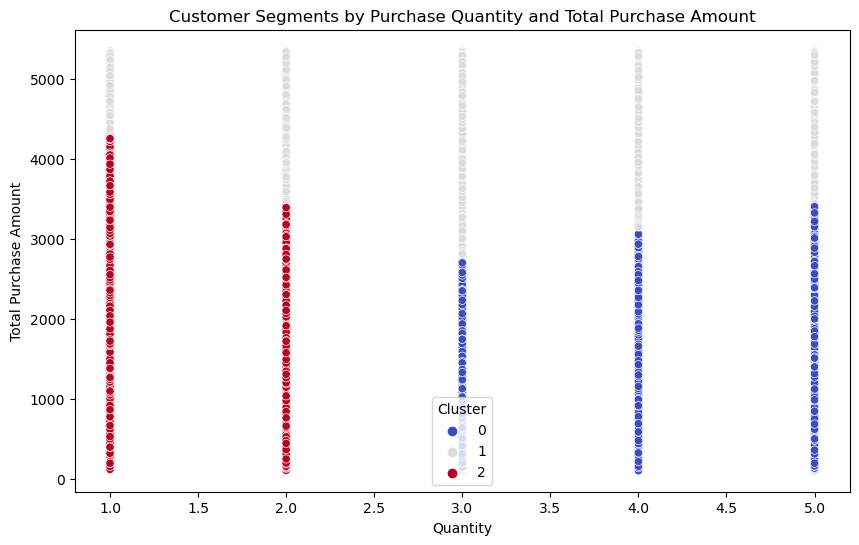

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
X = df[['Quantity', 'Total Purchase Amount']]  # Features for segmentation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize customer segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='Total Purchase Amount', hue='Cluster', data=df, palette='coolwarm')
plt.title('Customer Segments by Purchase Quantity and Total Purchase Amount')
plt.xlabel('Quantity')
plt.ylabel('Total Purchase Amount')
plt.legend(title='Cluster')
plt.show()

# Step 5. Insights and Recommendations

In [21]:
# Analyze customer segments
customer_segment_summary = df.groupby('Cluster').agg({
    'Customer ID': 'size',  # Counting the number of customers in each cluster
    'Total Purchase Amount': 'mean',  # Average purchase amount per cluster
    'Quantity': 'mean'  # Assuming 'Quantity' represents frequency or average purchases
}).rename(columns={'Customer ID': 'Customer Count', 'Total Purchase Amount': 'Avg. Purchase Amount', 'Quantity': 'Avg. Frequency'})
print("Customer Segment Summary:\n", customer_segment_summary)

Customer Segment Summary:
          Customer Count  Avg. Purchase Amount  Avg. Frequency
Cluster                                                      
0                 85184           1654.899864        4.081283
1                 92158           4226.276547        3.243994
2                 72658           2076.717154        1.439814


In [22]:
# Identify top-selling products
top_products = df['Product Category'].value_counts().nlargest(5)
print("Top 5 Selling Product Categories:\n", top_products)

Top 5 Selling Product Categories:
 Electronics    62630
Clothing       62581
Home           62542
Books          62247
Name: Product Category, dtype: int64


In [23]:
# Analyze trends in purchasing behavior
purchase_trend = df.groupby(df['Purchase Date'].dt.to_period('M')).agg({'Total Purchase Amount': 'sum'})
print("Purchase Trend Over Time:\n", purchase_trend)

Purchase Trend Over Time:
                Total Purchase Amount
Purchase Date                       
2020-01                     15566765
2020-02                     14660710
2020-03                     15517357
2020-04                     15060419
2020-05                     15517765
2020-06                     15062859
2020-07                     15575247
2020-08                     16190648
2020-09                     15134038
2020-10                     15758325
2020-11                     15281984
2020-12                     15551387
2021-01                     15415212
2021-02                     14310637
2021-03                     15386324
2021-04                     14955947
2021-05                     15597852
2021-06                     15103252
2021-07                     15811231
2021-08                     15914473
2021-09                     15174689
2021-10                     15514099
2021-11                     14725048
2021-12                     15763717
2022-01    

#### Recommendations based on findings
Recommendation 1: Target high-value customer segments with personalized promotions to increase retention and loyalty.

Recommendation 2: Focus marketing efforts on top-selling product categories to maximize revenue.

Recommendation 3: Analyze seasonal trends in purchasing behavior and launch targeted campaigns or discounts during peak seasons.

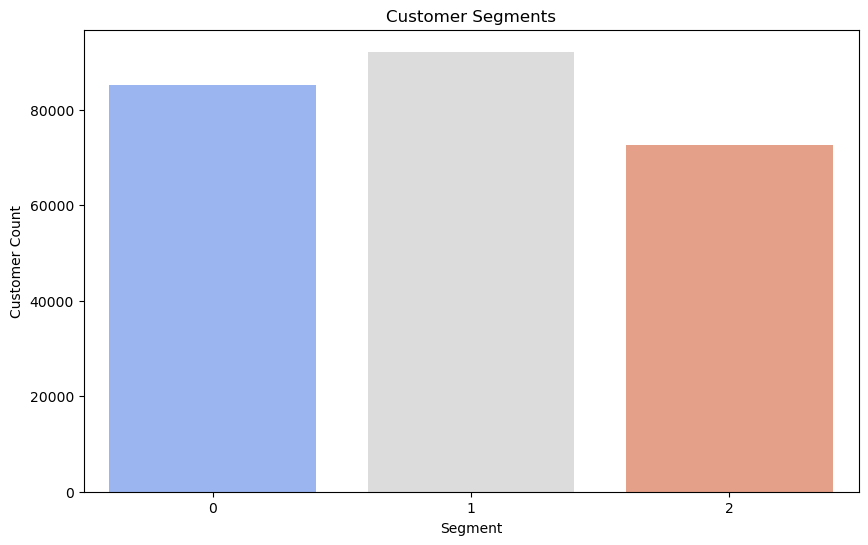

In [25]:
# Visualize customer segments
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df, palette='coolwarm')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Customer Count')
plt.show()

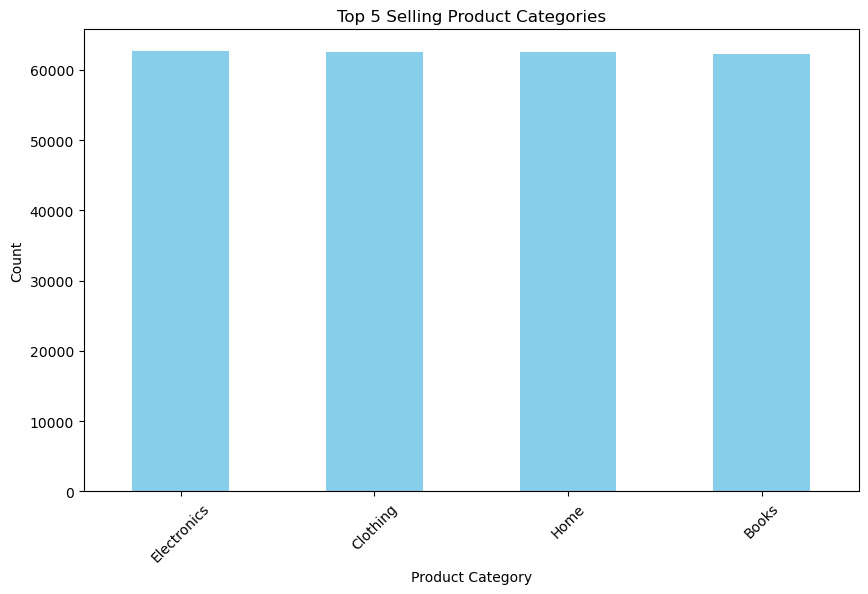

In [26]:
# Visualize top-selling products
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 5 Selling Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x600 with 0 Axes>

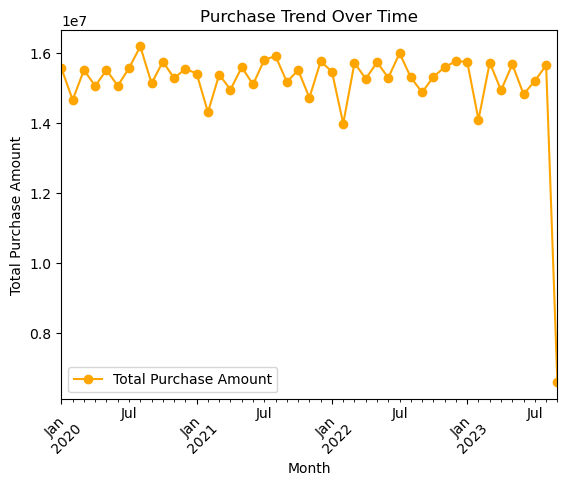

In [27]:
# Visualize purchase trend over time
plt.figure(figsize=(12, 6))
purchase_trend.plot(kind='line', color='orange', marker='o')
plt.title('Purchase Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()